In [3]:
# !pip install torch

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import torch.tensor
from torch.utils.data import random_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib as mpl
import pickle

In [5]:
#print(mpl.matplotlib_fname()) 
#!cd /opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf && ls -all

In [6]:
# Project setting
_using_cloud = True
if _using_cloud:
    from project_lib import Project 
    # Project id and access_token
    project = Project(project_id='8976f872-f678-426a-92f5-cd2267195121',
                      project_access_token='p-906af9388f829cd831410d7d2deb4d16f4bc504d')

# Unicode setting for displaying Chinese
fontP = font_manager.FontProperties()
font_name = 'SimHei'
if _using_cloud:
    simhei_ttf_name = font_name + '.ttf'
    simhei_ttf = project.get_file(simhei_ttf_name)
    mpl_fonts_ttf = '/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/' + simhei_ttf_name
    with open(mpl_fonts_ttf, "wb") as f:
        f.write(simhei_ttf.getbuffer())
    font_manager._rebuild()
    mpl.rcParams['font.family'] = [font_name]
    mpl.rcParams['axes.unicode_minus']=False
else:
    fontP.set_family('SimHei')
    fontP.set_size(14)

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
def get_ts_dxy(skip_day):
    data = pd.read_csv("https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv")
    searchfor = ['外地来','明确地区','不明地区','未知地区','未知','人员','待明确']
    data = data[~data['cityName'].str.contains('|'.join(searchfor))]
    data = data[~data['provinceName'].str.contains('|'.join(['香港','台湾','澳门']))]
    data = data[data['cityName'].groupby(data['cityName']).transform('size')>40]
    data['updateTime']=pd.to_datetime(data['updateTime']).dt.date
    grouped = data.sort_values('updateTime',ascending = False).groupby(['updateTime'])
    i = 0
    integrate = pd.DataFrame()
    for name,group in grouped:
        i +=1
        set_group = group.drop_duplicates(['provinceName','cityName'])
        set_group = set_group[['provinceName','cityName','city_confirmedCount','city_curedCount','city_deadCount']]
        set_group.rename(columns={"city_confirmedCount": "city_confirmedCount"+' '+str(name), 
                                  "city_curedCount": "city_curedCount"+' '+str(name),
                                  'city_deadCount': 'city_deadCount'+' '+str(name)}, inplace=True)
        if i<=skip_day:
            integrate = set_group
        else:
            integrate = integrate.merge(set_group, how = 'outer', on = ['provinceName','cityName'])
    integrate.dropna(thresh=len(integrate.columns)*0.9, inplace = True)
    integrate['ts']= integrate.iloc[:,2:].values.tolist()
    integrate = integrate[['provinceName','cityName','ts']].reset_index(drop=True)
    return integrate

In [9]:
def prepare_data(data,window):
    arraydata = []
    for index, row in data.iterrows():
        ts = np.diff(np.reshape(row.ts,(-1,3)),axis = 0)
        ts = ts[~np.isnan(ts).any(axis=1),:]
        for i in range(len(ts)-window+1):
            seq = ts[i:i+window]
            seq = np.nan_to_num(stats.zscore(seq, axis = 0))
            arraydata.append(seq)
    arraydata = torch.tensor(arraydata, dtype=torch.float)
    #split or not
    dataset = datasets(arraydata)
    train_len = int(dataset.__len__()*0.8)
    test_len = dataset.__len__()-train_len
    train_data, test_data = random_split(dataset,[train_len,test_len])
    return train_data, test_data

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :]) 
        return out
    
    
class datasets(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        target = self.data[index][-1]
        data_val = self.data[index] [:-1]
        return data_val,target

In [15]:
def training_model(train_data, test_data, num_epochs, batch_size=8, input_dim=3, hidden_dim=150, output_dim=3, seq_dim=7):
    
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    Mymodel = LSTMModel(input_dim, hidden_dim, 1, output_dim)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(Mymodel.parameters(), lr=0.01)
    iters = 0
    hisloss = []
    for epoch in range(num_epochs):
        for data_val,target in train_loader:
            # clean the previous gredient
            optimizer.zero_grad()
            outputs = Mymodel(data_val)
            #calculate loss
            loss = loss_function(outputs, target)
            hisloss.append(loss.item())
            # using loss to calculate gredient, stored in model
            loss.backward()
            # using gredient to update model parameters
            optimizer.step()
            iters += 1
            if iters % 300 ==0:
                for test_val,test_target in test_loader:
                    test_outputs = Mymodel(test_val)
                    loss2 = loss_function(test_outputs, test_target)
                print('Iteration: {}. TrainLoss: {}. TestLoss: {}'.format(iters, loss.item(), loss2.item()))
                model_folder, model_filename = 'Trained_model/', 'trained_model_{0}.pkl'.format(str(iters))
                state_dict = Mymodel.state_dict()
                if _using_cloud:
                    project.save_data(model_filename, pickle.dumps(state_dict), overwrite=True)
#                     torch.save(Mymodel.state_dict())
                else:
                    torch.save(state_dict, model_folder + model_filename)
    plt.plot(hisloss)
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.title('Traing process')
    plt.grid(True)
    plt.show()
    model_folder, fig_filename = 'Trained_model/', 'loss.png'
    if _using_cloud:
        fig_handle = plt.figure()
        project.save_data(fig_filename, pickle.dumps(fig_handle), overwrite=True)
    else:
        plt.savefig(model_folder + fig_filename)        
    return Mymodel

In [16]:
def evaluation(provincename, cityname, modelpath, data):
    Mymodel = LSTMModel(3, 150, 1, 3)
#     Mymodel.load_state_dict(torch.load(modelpath))
    model_folder, model_filename = modelpath.split('/')
    if _using_cloud:
        state_dict = pickle.load(project.get_file(model_filename))
    else:
        state_dict = torch.load(modelpath)
    Mymodel.load_state_dict(state_dict)
    series = data.loc[(data["provinceName"] == provincename) & (data["cityName"] == cityname), "ts"].values.tolist()
    series = np.reshape(series,(-1,3))
    if np.isnan(series[-1][0]):
        series = series[:-1]
    diff_series = np.diff(series,axis = 0)
    n = len(diff_series)
    seq = []
    predict_series = []
    predict_series[:] = series[0:7]
    store_diff = []
    store_diff[:] = diff_series[0:7]
    for i in range(n):
        seq[:] = diff_series[i:i+7]
        mean = np.mean(seq,axis = 0)
        std = np.std(seq,axis = 0)
        seq -= mean
        seq /= std
        tensor_seq = torch.tensor(np.nan_to_num([seq]), dtype=torch.float, requires_grad=False)
        predictions = np.array(Mymodel(tensor_seq).tolist()[0])
        real_diff = predictions * std + mean
        store_diff = np.append(store_diff,[real_diff],axis = 0)
        if i>=n-7:
            diff_series = np.append(diff_series,[real_diff],axis = 0)
            predict_series = np.append(predict_series,[np.array(list(map(sum,zip(predict_series[-1],real_diff))))],axis = 0)
        else:
            predict_series = np.append(predict_series,[np.array(list(map(sum,zip(series[i+6],real_diff))))],axis = 0)
    return series, predict_series, provincename+cityname, store_diff, diff_series

In [17]:
def draw_plot(origin,pred,title):
#     fontP = font_manager.FontProperties()
#     fontP.set_family('SimHei')
#     fontP.set_size(14)
    
    x1 = origin[:,0]
    x2 = pred[:,0]
    plt.plot(x1, label = "True_value")
    plt.plot(x2, label = "Predicted_value")
    plt.xlabel('Time (days)')
    plt.ylabel('Infections')
    
    if _using_cloud:
        plt.title(title)
    else:
        plt.title(title,fontproperties=fontP)
        
    plt.legend()
    plt.grid(True)
    plt.show()
    return

/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Iteration: 300. TrainLoss: 0.13523747026920319. TestLoss: 0.042914945632219315
Iteration: 600. TrainLoss: 0.01757657341659069. TestLoss: 0.08681253343820572
Iteration: 900. TrainLoss: 0.03424668312072754. TestLoss: 0.02284103073179722
Iteration: 1200. TrainLoss: 0.027363227680325508. TestLoss: 0.014955289661884308
Iteration: 1500. TrainLoss: 0.0249274130910635. TestLoss: 0.00925805326551199
Iteration: 1800. TrainLoss: 0.0028581609949469566. TestLoss: 0.0018372396007180214
Iteration: 2100. TrainLoss: 0.009440416470170021. TestLoss: 0.007325705606490374
Iteration: 2400. TrainLoss: 0.005328867584466934. TestLoss: 0.006592519115656614
Iteration: 2700. TrainLoss: 0.0024023004807531834. TestLoss: 0.005450964439660311
Iteration: 3000. TrainLoss: 0.0034167247358709574. TestLoss: 0.011942259967327118
Iteration: 3300. TrainLoss: 0.0027477573603391647. TestLoss: 0.00830554123967886
Iteration: 3600. TrainLoss: 0.002489108359441161. TestLoss: 0.0035637340042740107
Iteration: 3900. TrainLoss: 0.0103

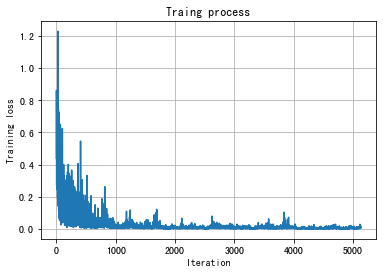

<Figure size 432x288 with 0 Axes>

In [18]:
if __name__ == "__main__":
    ## custimized part
    data = get_ts_dxy(1)
    train,test = prepare_data(data,8)
    Mymodel = training_model(train,test, num_epochs = 6)

In [ ]:
    modelpath = 'Trained_model/trained_model_2100.pkl' 
    origin , predictions, title, store_diff, diff_series  = evaluation('湖北省', '武汉', modelpath, data)
    draw_plot(origin , predictions, title)

In [ ]:
    draw_plot(diff_series, store_diff, title+'difference')